# Data Cleaning and Sentiment Analysis
Source: https://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk

In [205]:
import os
import json
import time
import requests
import datetime
import dateutil
import numpy as np
import pandas as pd
import glob
import string, re
import nltk
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk import FreqDist

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\smuke\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\smuke\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\smuke\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\smuke\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [151]:
# Read in the articles csv
articles = pd.read_csv("./headlines/NYTData.csv")
articles = articles.drop(columns=["doc_type", "material_type", "section", "keywords"])
articles = articles.dropna()

In [152]:
# How to check is a word is in the dataframe
# 'Adele' in names.names.values
# Create the different candidate/party dataframes
articlesR = (articles["headline"].str.contains("Trump|GOP|Republican|Pence"))
articlesR.fillna(False, inplace=True)
articlesR = articles[articlesR]
articlesD = (articles["headline"].str.contains("Biden|Progressive|Democrat|Harris"))
articlesD.fillna(False, inplace=True)
articlesD = articles[articlesD]


In [178]:
#Removing punctuation from headlines
def removePunctuation(articles):
    for i in range(len(articles)):
        headline = articles.iloc[i][0]
        text = headline.translate(str.maketrans('', '', string.punctuation)).lower()
        text = text.replace("‘","")
        text = text.replace("’","")
        text = text.replace("trump", "Trump")
        text = text.replace("Trumps", "Trump")
        articles.iloc[i][0] = text
    return articles

def groupByDate(articles):
    articles = articles.groupby(["date"]).agg(lambda s: " ".join(s))
    return articles

def tokenize(headlines):
    return headlines.apply(lambda s: word_tokenize(s))

def remove_noise(tweet_tokens, stop_words = ()):
    '''
    from https://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk
    
    '''
    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

def all_words_generator(tokenslst):
    for tokens in tokenslst:
        for token in tokens:
            yield token

In [154]:
# Tokenize the data and remove punctuation
articlesR = removePunctuation(articlesR)
articlesD = removePunctuation(articlesD)
articlesR["tokens"] = tokenize(articlesR["headline"])
articlesD["tokens"] = tokenize(articlesD["headline"])
articlesR.head() #Verify that the data look good

<ipython-input-154-ec83fadccec4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articlesR["tokens"] = tokenize(articlesR["headline"])
<ipython-input-154-ec83fadccec4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articlesD["tokens"] = tokenize(articlesD["headline"])


,headline,date,tokens
11,in pictures Trump busy week before testing pos...,2020-10-02,"[in, pictures, Trump, busy, week, before, test..."
18,a top Trump aide has tested positive for the v...,2020-10-02,"[a, top, Trump, aide, has, tested, positive, f..."
20,Trump administration opens investigation into ...,2020-10-02,"[Trump, administration, opens, investigation, ..."
38,Trump hospitalization starts to affect the cam...,2020-10-03,"[Trump, hospitalization, starts, to, affect, t..."
39,Trump covid treatments are aimed at preventing...,2020-10-03,"[Trump, covid, treatments, are, aimed, at, pre..."


In [162]:
#Lemmatize each headline and reset the indicies
stop_words = stopwords.words("english")
articlesD["tokens"] = articlesD["tokens"].apply(lambda s: remove_noise(s, stop_words))
articlesR["tokens"] = articlesR["tokens"].apply(lambda s: remove_noise(s, stop_words))
articlesR = articlesR.reset_index()
articlesD = articlesD.reset_index()


In [194]:
# Generate the frequency lists for both sets
demFreqList = FreqDist(all_words_generator(articlesD["tokens"].tolist()))
repFreqList = FreqDist(all_words_generator(articlesR["tokens"].tolist()))

In [271]:
# Plot top 10 frequency words for both
rep = repFreqList.most_common(10)
dem = demFreqList.most_common(10)
# x, y = x.T
# plt.hist(x)
# x
# repFreqList.plot.hist(grid=True,
#                    color='#607c8e')
# plt.hist(repFreqList)
# plt.colorbar('#607c8e')
# plt.title('Frequency of top 10 words for Republican/Trump Articles')
# plt.xlabel('Counts')
# plt.ylabel('Word')
# plt.grid(axis='y', alpha=0.75)

In [149]:
#Removing duplicate words from headlines and counting them
# for i in range(len(articles)):
#     s = {}
#     for name in nameSet:
#         if name in articles["headline"][i]:
#             if name in s:
#                 s[name] += 1
#             else:
#                 s[name] = 1
#             articles["headline"][i].replace(name, "")
#     for name in locationSet:
#         if name in articles["headline"][i]:
#             if name in s:
#                 s[name] += 1
#             else:
#                 s[name] = 1
#             articles["headline"][i].replace(name, "")
#     for word in articles["headline"][i].split():
#         word = word.replace("‘", "")
#         word = word.replace("’", "")
#         if word in s:
#             s[word] += 1
#         else:
#             s[word] = 1
#     articles["headline"][i] = s
articles.to_csv("./data/NYTDataCleaned.csv")

Text(0, 0.5, 'Number of Appearances')

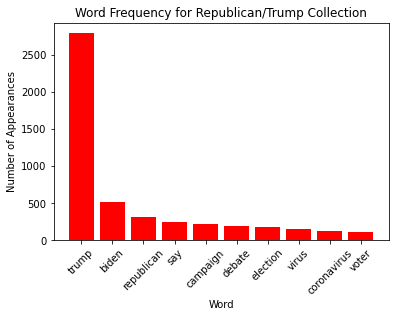

In [274]:
# Rep plot
plt.bar(*zip(*dict(rep).items()), color="red")
plt.xticks(rotation=45)
plt.title("Word Frequency for Republican/Trump Collection")
plt.xlabel("Word")
plt.ylabel("Number of Appearances")

Text(0, 0.5, 'Number of Appearances')

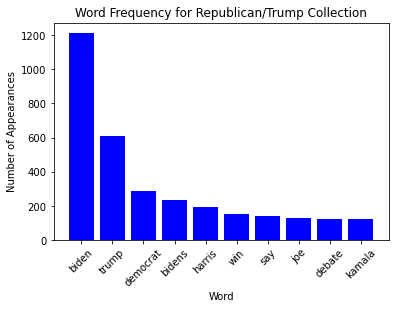

In [273]:
# Dem plot
plt.bar(*zip(*dict(dem).items()), color="blue")
plt.xticks(rotation=45)
plt.title("Word Frequency for Republican/Trump Collection")
plt.xlabel("Word")
plt.ylabel("Number of Appearances")